In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from math import ceil
import seaborn as sns
from scipy import stats

In [2]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [3]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Patient Real Heart Rate')
    plt.plot(predicted, color='blue',label='Patient Predicted Heart Rate')
    plt.title('Heart Rate Prediction')
    plt.xlabel('Time')
    plt.ylabel('mV')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    mae =mean_absolute_error(test, predicted)
    print(f"The mean absolute error is {mae}.")

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [5]:
def create_time_steps(length):
    return list(range(-length, 0))

In [6]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History',kind='line')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future',kind='line')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In [7]:
tf.random.set_seed(13)

In [8]:
df = pd.read_csv('14046_2teste.csv', index_col='t')
df.head()

,mV
t,
0.000,0.16
0.008,0.18
0.016,0.17
0.023,0.18
0.031,0.18


In [9]:
int(df.shape[0] * 0.5)

9668

In [10]:
df.sample(5)

,mV
t,
61.594,0.76
79.711,-1.82
96.234,-1.81
148.656,0.07
5.141,-0.02


## Training for 60% of the base

In [11]:
train = df.iloc[0:int(df.shape[0]*0.5)].values

In [12]:
test = df.iloc[int(df.shape[0]*0.5):].values

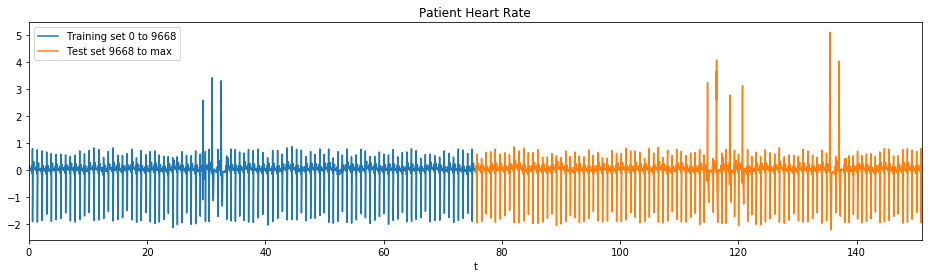

In [13]:
df["mV"].iloc[0:int(df.shape[0]*0.5)].plot(figsize=(16,4),legend=True)
df["mV"].iloc[int(df.shape[0]*0.5):].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set 0 to {int(df.shape[0]/2)}',f'Test set {int(df.shape[0]/2)} to max'])
plt.title('Patient Heart Rate')
plt.show()

In [14]:
uni_data = df['mV']
uni_data.head()

t
0.000    0.16
0.008    0.18
0.016    0.17
0.023    0.18
0.031    0.18
Name: mV, dtype: float64

In [15]:
uni_data = uni_data.values

In [16]:
uni_train_mean = uni_data[:int(df.shape[0]*0.5)].mean()
uni_train_std = uni_data[:int(df.shape[0]*0.5)].std()

In [17]:
uni_train_mean

-0.01317335539925527

In [18]:
uni_train_std

0.33492606608181086

Let's standardize the data.

In [19]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [20]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, int(df.shape[0]*0.5),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, int(df.shape[0]*0.5), None,
                                       univariate_past_history,
                                       univariate_future_target)

In [21]:
y_train_uni

array([ 0.03933213,  0.0990468 ,  0.12890414, ..., -0.13981188,
       -0.13981188, -0.10995455])

# Model testing

In [22]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(1))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [23]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(1000).batch(500).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(1000).repeat()

In [24]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=10,
                                          steps_per_epoch=100,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/10
  7/100 [=>............................] - ETA: 27s - loss: 0.4347

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-59d5221bc6ba>", line 4, in <module>
    validation_steps=50)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 324, in fit
    total_epochs=epochs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 123, in run_one_epoch
    batch_outs = execution_function(iterator)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2_utils.py", line 86, in execution_function
    distributed_function(input_fn))
  File "C:\ProgramData\Anaconda3\lib\site-packages\t

KeyboardInterrupt: 

## Multi-Step Training

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
val_data_multi.take(30)

In [ ]:
STEP = 1

In [ ]:
x = val_data_multi.take(10)

## Testing Out

In [ ]:
dataset_total = pd.concat((df["mV"].iloc[0:int(df.shape[0]*0.4)],df["mV"].iloc[int(df.shape[0]*0.4):]),axis=0)

In [ ]:
len(dataset_total)-len(test)-15

In [ ]:
dataset_total.shape

In [ ]:
19337 - 7719

In [ ]:
len(dataset_total)-len(test) - 15

In [ ]:
len(dataset_total)

In [ ]:
len(test)

In [ ]:
inputs = dataset_total.iloc[len(dataset_total)-len(test) - 15:].values
inputs = inputs.reshape(-1,1)
#inputs  = sc.transform(inputs)

In [ ]:
inputs.shape

In [ ]:
X_test = []
for j in range(15,11618):
    X_test.append(inputs[j-15:j,0])

In [ ]:
X_test

In [ ]:
X_test = np.array(X_test)

In [ ]:
X_test

In [158]:
X_test.shape

(11603, 15)

In [159]:
X_test.shape[0]

11603

In [160]:
X_test.shape[1]

15

In [161]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [162]:
predicted_heart_rate = multi_step_model.predict(X_test)

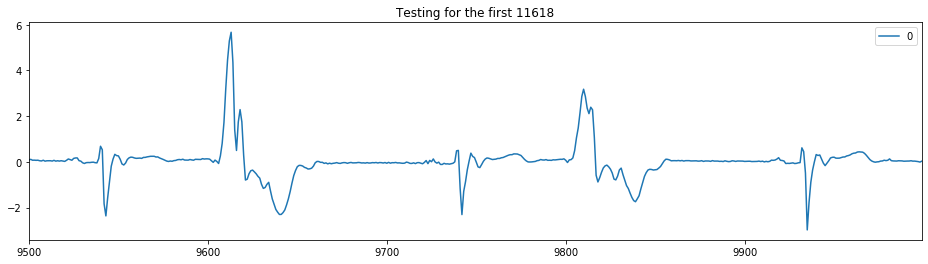

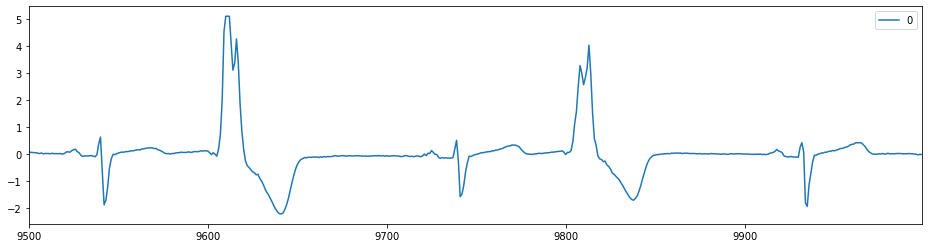

In [163]:
plt.figure(figsize=[20,10])
plt.title(f'Testing for the first {11618}')
pd.DataFrame(predicted_heart_rate)[0].iloc[9500:10000].plot(figsize=(16,4),legend=True)
pd.DataFrame(test).iloc[9500:10000].plot(figsize=(16,4),legend=True)
plt.show()

Testing for 14% of the test

result for ks on test is KstestResult(statistic=0.38806423524324907, pvalue=2.133743088325405e-223)
result for ks on prediction is KstestResult(statistic=0.3912117901533352, pvalue=3.5999202561513626e-227)
Results for spearman correlation is SpearmanrResult(correlation=0.15939115113546795, pvalue=8.064451229907983e-11)


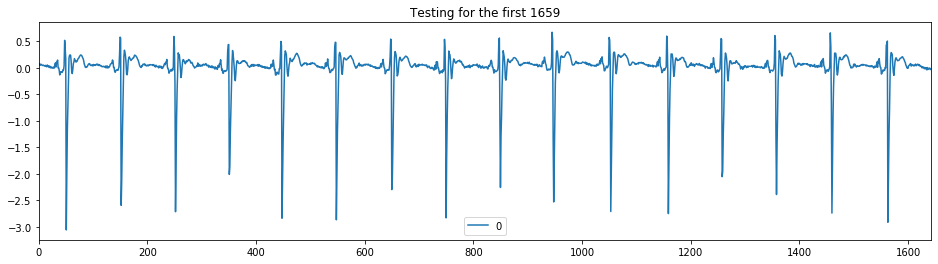

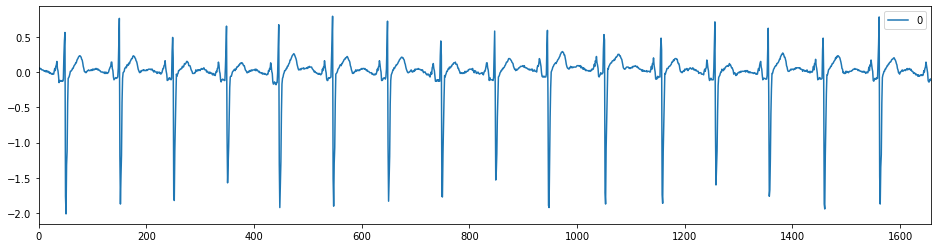

Testing for 16% of the test

result for ks on test is KstestResult(statistic=0.38498590357514506, pvalue=1.112371363249871e-256)
result for ks on prediction is KstestResult(statistic=0.38948386560065773, pvalue=6.1878511832117405e-263)
Results for spearman correlation is SpearmanrResult(correlation=0.16633620930260892, pvalue=2.1875108674962796e-13)


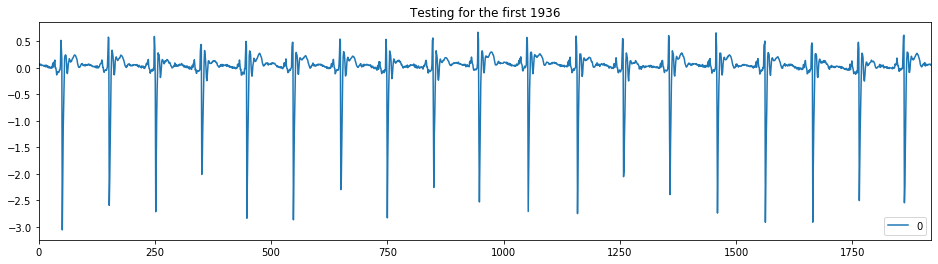

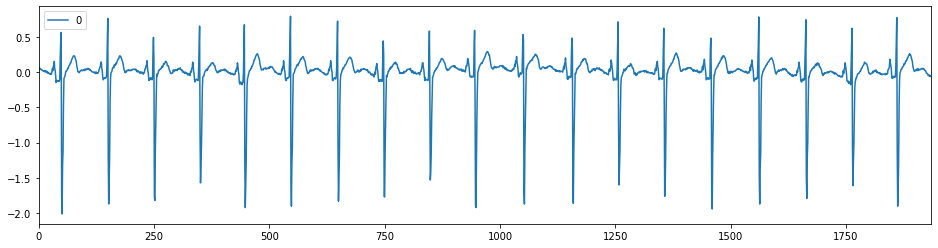

Testing for 19% of the test

result for ks on test is KstestResult(statistic=0.38545825667299516, pvalue=4.514358151544666e-309)
result for ks on prediction is KstestResult(statistic=0.3894723627095978, pvalue=8.7841621e-316)
Results for spearman correlation is SpearmanrResult(correlation=0.17096116952055931, pvalue=1.3422988282690449e-16)


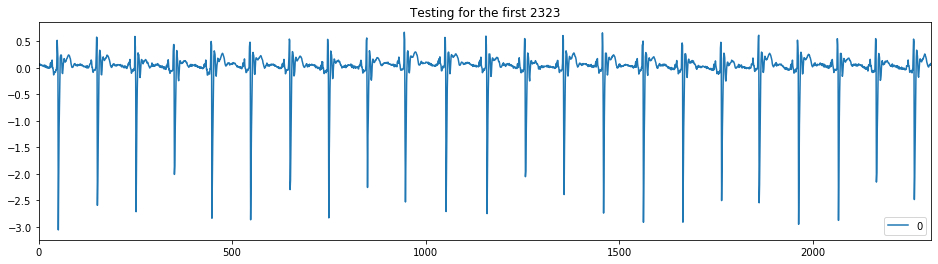

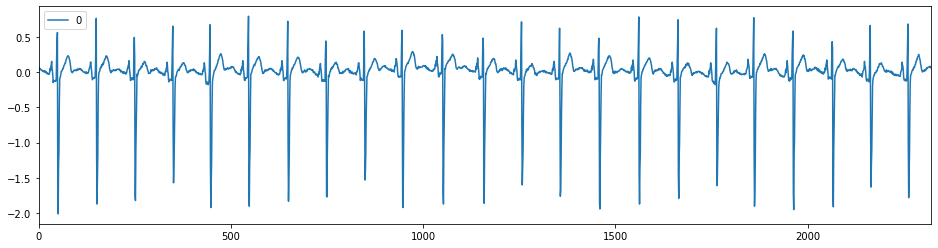

Testing for 24% of the test

result for ks on test is KstestResult(statistic=0.38701633899445237, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.38996774643275905, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.1898575974384888, pvalue=7.4931331692115305e-25)


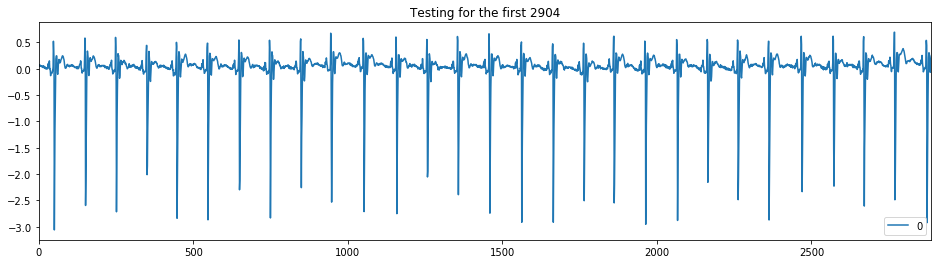

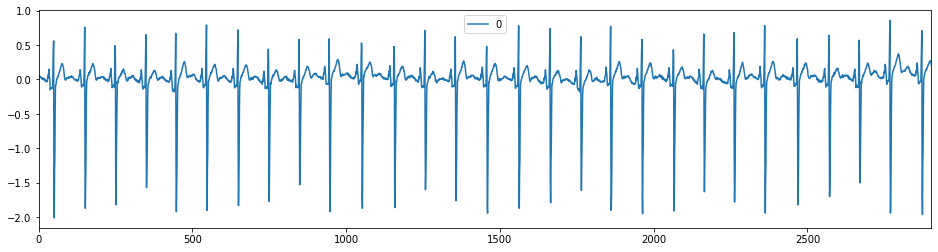

Testing for 33% of the test

result for ks on test is KstestResult(statistic=0.38839210626739895, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.39186972922336627, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.20535105696199113, pvalue=5.347680261734434e-38)


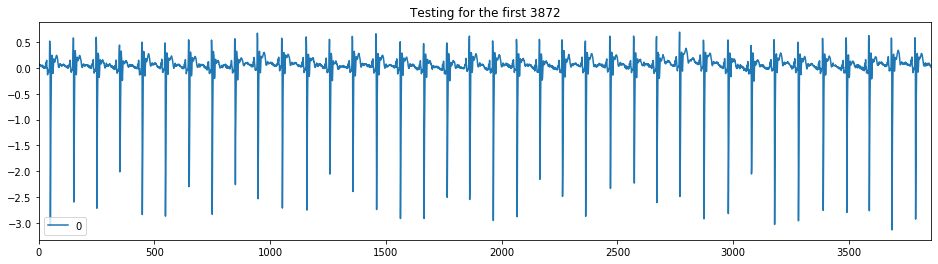

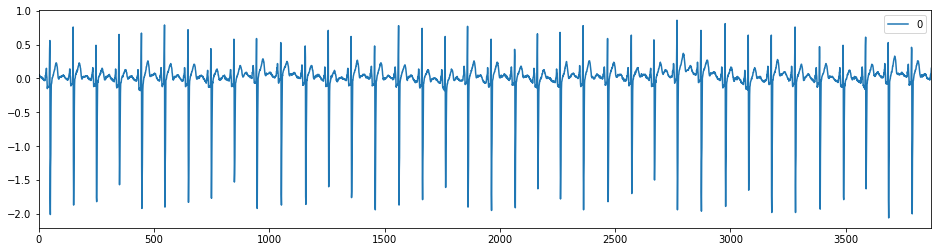

Testing for 49% of the test

result for ks on test is KstestResult(statistic=0.3872019316801136, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.3917870596702102, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.20639946454660762, pvalue=8.906613828615305e-57)


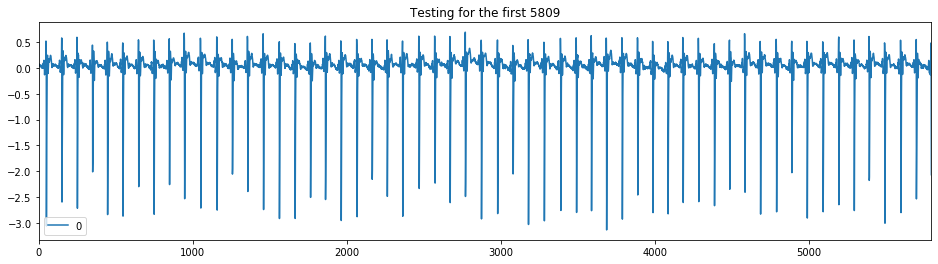

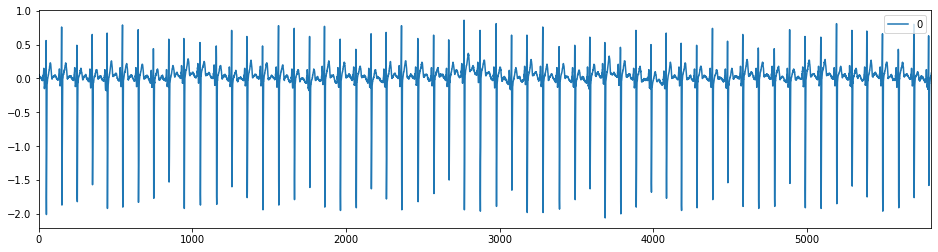

Testing for 99% of the test

result for ks on test is KstestResult(statistic=0.37219347877592585, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.37437932518834816, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.7675384948318573, pvalue=0.0)


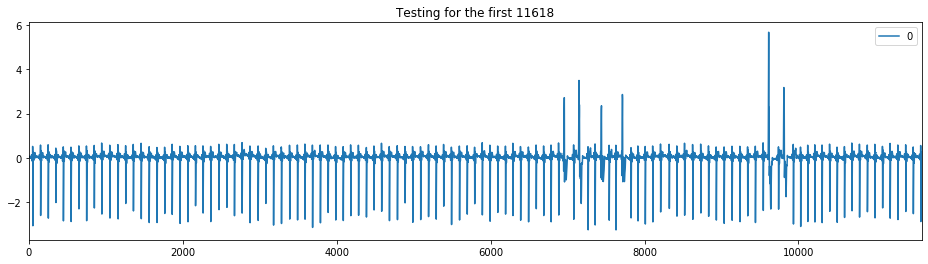

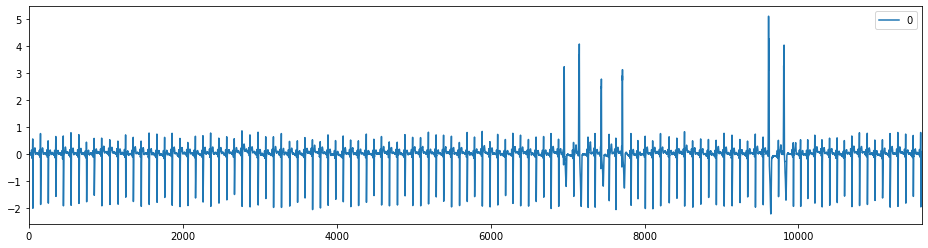

In [164]:
for i in [7,6,5,4,3,2,1]:
    X_test = []
    for j in range(15,int(11618/i)):
        X_test.append(inputs[j-15:j,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    predicted_heart_rate = multi_step_model.predict(X_test)
    if (pd.DataFrame(predicted_heart_rate)[0].shape[0] + 15) < 11000:
        test_pred = pd.DataFrame(test).iloc[15:(pd.DataFrame(predicted_heart_rate)[0].shape[0] + 15)]
    else:
        test_pred = pd.DataFrame(test)
    
    print(f'Testing for {int((test_pred.shape[0] / 11618) * 100)}% of the test')
    print('')
    ks_test = stats.kstest(np.array(pd.DataFrame(test_pred)[0]),'norm')
    ks_pred = stats.kstest(np.array(pd.DataFrame(predicted_heart_rate)[0]),'norm')
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(test_pred)[0]),np.array(pd.DataFrame(predicted_heart_rate)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(test_pred)[0])),(np.array(pd.DataFrame(predicted_heart_rate)[0])))}')
        #pass
    plt.figure(figsize=[20,10])
    plt.title(f'Testing for the first {int(11618/i)}')
    pd.DataFrame(predicted_heart_rate)[0].iloc[0:int(11618/i)].plot(figsize=(16,4),legend=True)
    pd.DataFrame(test).iloc[0:int(11618/i)].plot(figsize=(16,4),legend=True)
    plt.show()

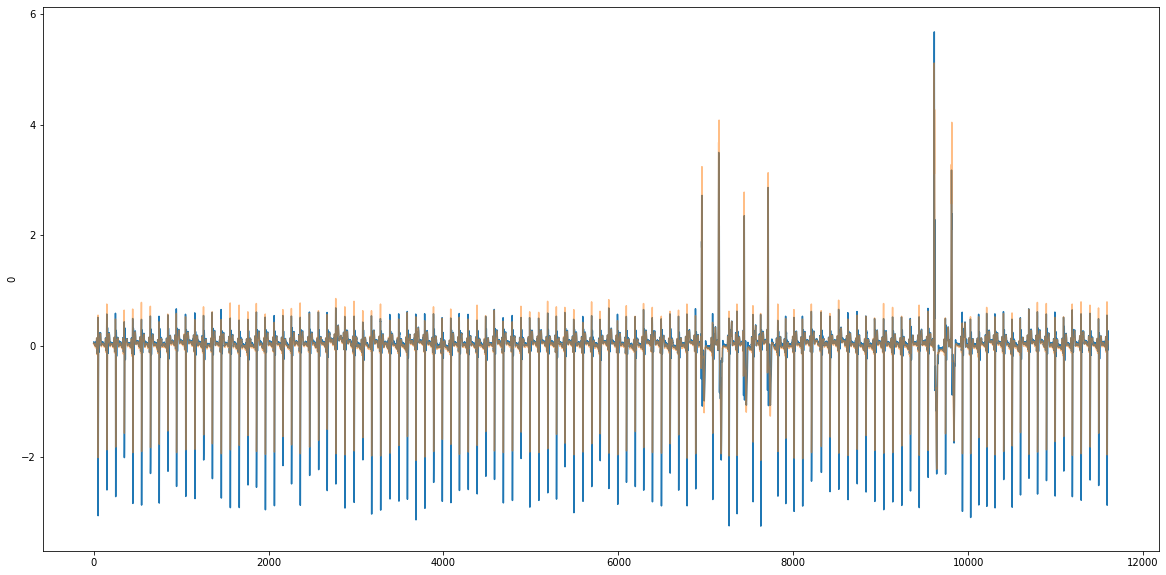

In [165]:
plt.figure(figsize=[20,10])
sns.lineplot(y=pd.DataFrame(predicted_heart_rate)[0],x=pd.DataFrame(predicted_heart_rate).index)
sns.lineplot(y=pd.DataFrame(test).iloc[0:int(11618/i)][0],x=pd.DataFrame(test).iloc[0:int(11618/i)].index,alpha=0.5)
plt.show()

In [166]:
test_pred

,0
0,0.05
1,0.06
2,0.04
3,0.05
4,0.05
...,...
11598,0.05
11599,0.05
11600,0.08
11601,0.09


In [167]:
merged = pd.merge(test_pred,pd.DataFrame(predicted_heart_rate),left_index=True,right_index=True).rename(columns={'0_x' : 'True','0_y' : 'Pred'})

In [168]:
merged.dtypes

True    float64
Pred    float32
dtype: object

In [169]:
merged['Pred'] = merged['Pred'].astype(float)

In [170]:
merged.dtypes

True    float64
Pred    float64
dtype: object

In [171]:
merged.to_csv('true_vs_pred.csv',encoding='UTF-8',sep=',')

![Amostra de súbida](sample.png)

## É notável que o modelo preve os pontos bem próximos do Real, percebemos pela imagem que o modelo leva um tempo para chegar aos 5.11 mV e ele decresce bem rápido também, todavia, capturando a mesma forma de onda.

## Esse momento ocorre em torno de 9600 ~ 9650 de index

## Agora testando na base com uma onda quadrada

In [182]:
df = pd.read_csv('data_with_quadratic_wave.csv', index_col='t')

In [183]:
dataset_total = pd.concat((df["mV"].iloc[0:7734],df["mV"].iloc[7734:]),axis=0)

In [186]:
len(dataset_total)-len(test)-15

8219

In [187]:
dataset_total.shape

(19837,)

In [199]:
19837 - 8219

11618

In [189]:
len(dataset_total)-len(test) - 15

8219

In [190]:
inputs = dataset_total.iloc[len(dataset_total)-len(test) - 15:].values
inputs = inputs.reshape(-1,1)
#inputs  = sc.transform(inputs)

In [191]:
inputs.shape

(11618, 1)

In [200]:
X_test = []
for j in range(15,11618):
    X_test.append(inputs[j-15:j,0])

In [201]:
X_test

[array([0.04, 0.04, 0.03, 0.05, 0.05, 0.05, 0.05, 0.06, 0.04, 0.05, 0.05,
        0.05, 0.05, 0.06, 0.05]),
 array([0.04, 0.03, 0.05, 0.05, 0.05, 0.05, 0.06, 0.04, 0.05, 0.05, 0.05,
        0.05, 0.06, 0.05, 0.07]),
 array([0.03, 0.05, 0.05, 0.05, 0.05, 0.06, 0.04, 0.05, 0.05, 0.05, 0.05,
        0.06, 0.05, 0.07, 0.06]),
 array([0.05, 0.05, 0.05, 0.05, 0.06, 0.04, 0.05, 0.05, 0.05, 0.05, 0.06,
        0.05, 0.07, 0.06, 0.07]),
 array([0.05, 0.05, 0.05, 0.06, 0.04, 0.05, 0.05, 0.05, 0.05, 0.06, 0.05,
        0.07, 0.06, 0.07, 0.08]),
 array([0.05, 0.05, 0.06, 0.04, 0.05, 0.05, 0.05, 0.05, 0.06, 0.05, 0.07,
        0.06, 0.07, 0.08, 0.07]),
 array([0.05, 0.06, 0.04, 0.05, 0.05, 0.05, 0.05, 0.06, 0.05, 0.07, 0.06,
        0.07, 0.08, 0.07, 0.07]),
 array([0.06, 0.04, 0.05, 0.05, 0.05, 0.05, 0.06, 0.05, 0.07, 0.06, 0.07,
        0.08, 0.07, 0.07, 0.07]),
 array([0.04, 0.05, 0.05, 0.05, 0.05, 0.06, 0.05, 0.07, 0.06, 0.07, 0.08,
        0.07, 0.07, 0.07, 0.07]),
 array([0.05, 0.05, 0.05, 0.

In [202]:
X_test = np.array(X_test)

In [203]:
X_test

array([[ 0.04,  0.04,  0.03, ...,  0.05,  0.06,  0.05],
       [ 0.04,  0.03,  0.05, ...,  0.06,  0.05,  0.07],
       [ 0.03,  0.05,  0.05, ...,  0.05,  0.07,  0.06],
       ...,
       [-1.  , -1.  , -1.  , ..., -1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  , ..., -1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  , ..., -1.  , -1.  , -1.  ]])

In [204]:
X_test.shape

(11603, 15)

In [205]:
X_test.shape[0]

11603

In [206]:
X_test.shape[1]

15

In [207]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [208]:
predicted_heart_rate = multi_step_model.predict(X_test)

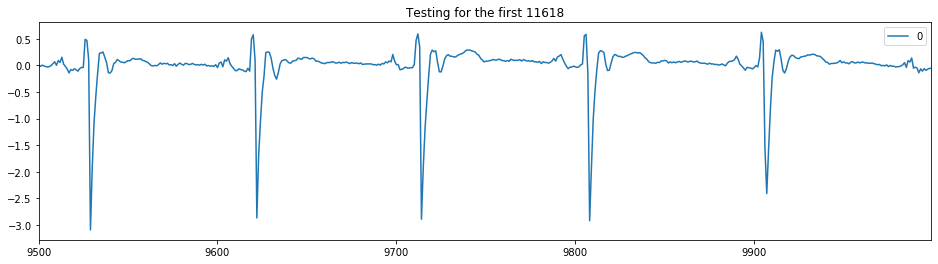

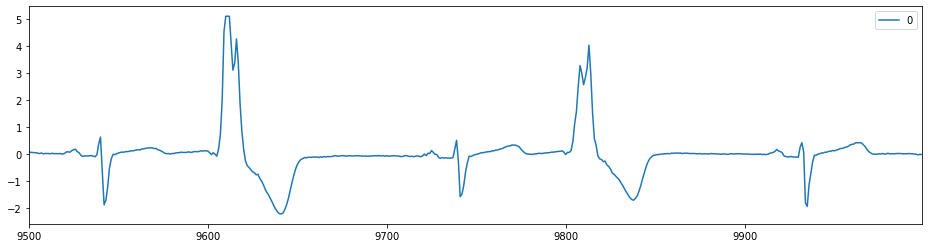

In [209]:
plt.figure(figsize=[20,10])
plt.title(f'Testing for the first {11618}')
pd.DataFrame(predicted_heart_rate)[0].iloc[9500:10000].plot(figsize=(16,4),legend=True)
pd.DataFrame(test).iloc[9500:10000].plot(figsize=(16,4),legend=True)
plt.show()

Testing for 14% of the test

result for ks on test is KstestResult(statistic=0.38806423524324907, pvalue=2.133743088325405e-223)
result for ks on prediction is KstestResult(statistic=0.3944000283582407, pvalue=4.994015528310153e-231)
Results for spearman correlation is SpearmanrResult(correlation=0.04128296864904952, pvalue=0.09426617262139028)


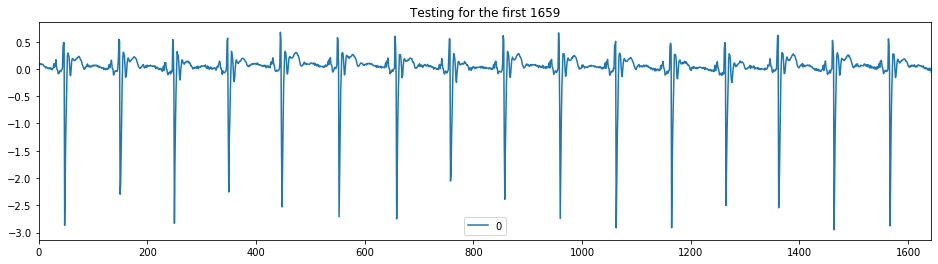

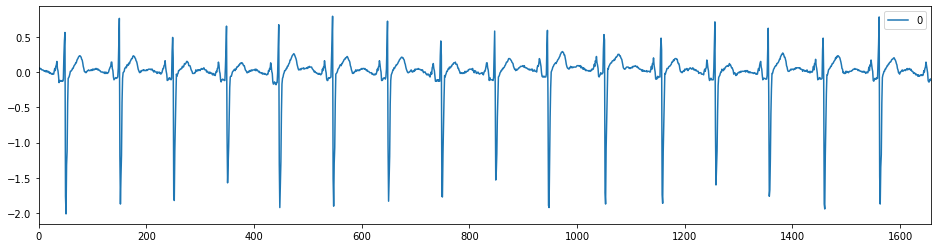

Testing for 16% of the test

result for ks on test is KstestResult(statistic=0.38498590357514506, pvalue=1.112371363249871e-256)
result for ks on prediction is KstestResult(statistic=0.39232696219617735, pvalue=6.229002528632078e-267)
Results for spearman correlation is SpearmanrResult(correlation=0.06264889517545322, pvalue=0.006018661712935257)


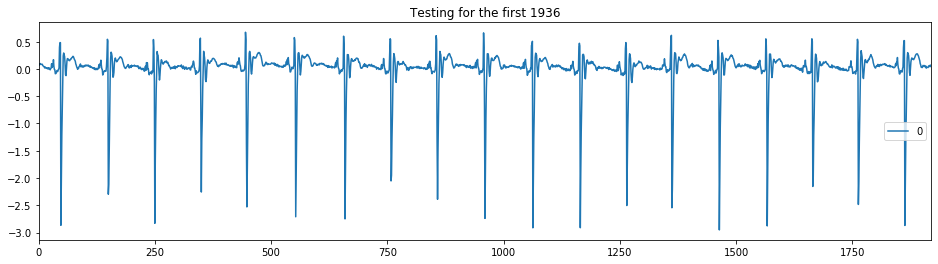

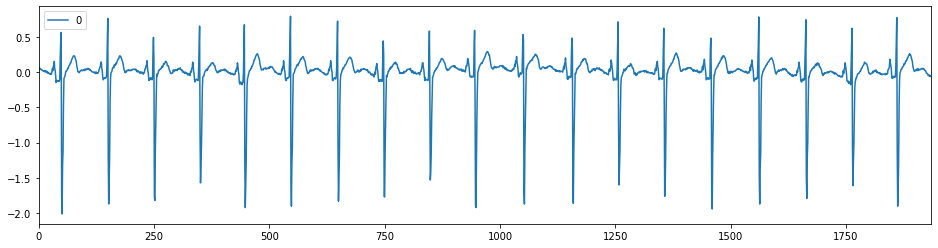

Testing for 19% of the test

result for ks on test is KstestResult(statistic=0.38545825667299516, pvalue=4.514358151544666e-309)
result for ks on prediction is KstestResult(statistic=0.3914125208751002, pvalue=4.68463e-319)
Results for spearman correlation is SpearmanrResult(correlation=0.03623849988126871, pvalue=0.08175620221606586)


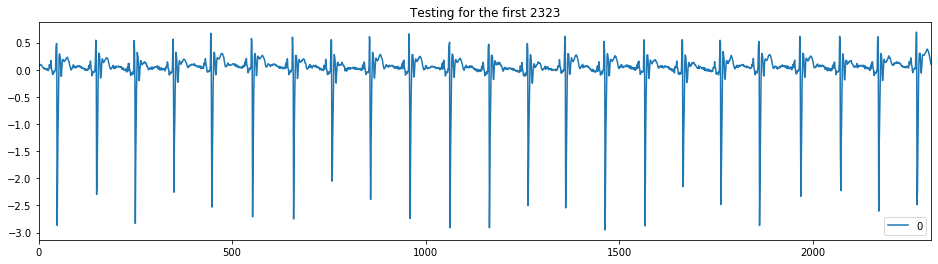

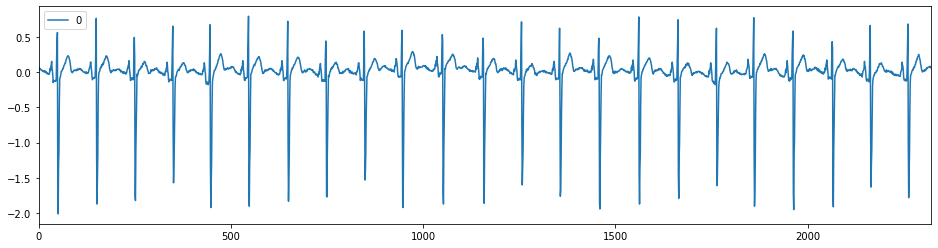

Testing for 24% of the test

result for ks on test is KstestResult(statistic=0.38701633899445237, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.3936934061153132, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.03657078273179025, pvalue=0.04936043264171425)


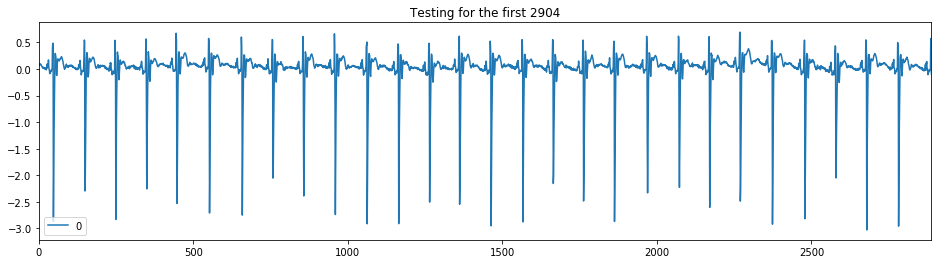

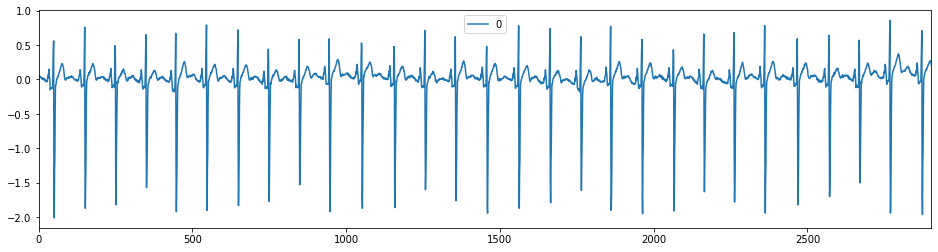

Testing for 33% of the test

result for ks on test is KstestResult(statistic=0.38839210626739895, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.3925349708175623, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.059508450074198624, pvalue=0.00021744468567210816)


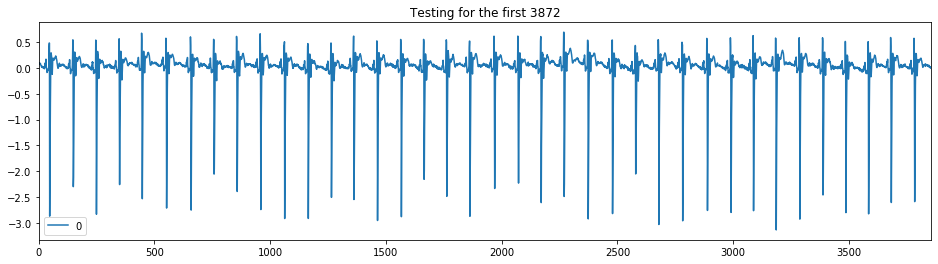

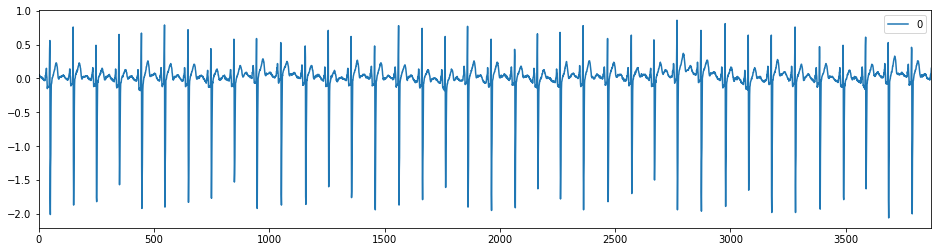

Testing for 49% of the test

result for ks on test is KstestResult(statistic=0.3872019316801136, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.39188177677897185, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.06656360723862795, pvalue=3.9522778338831546e-07)


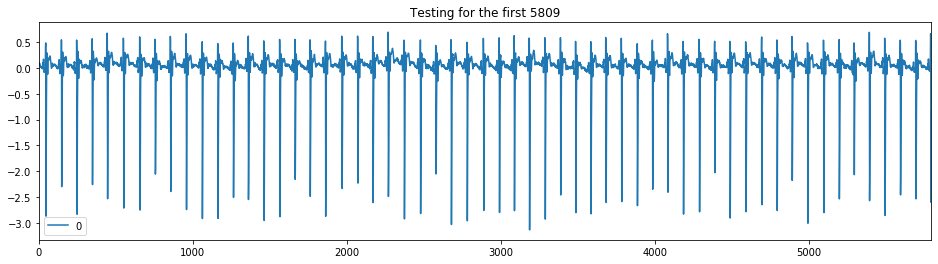

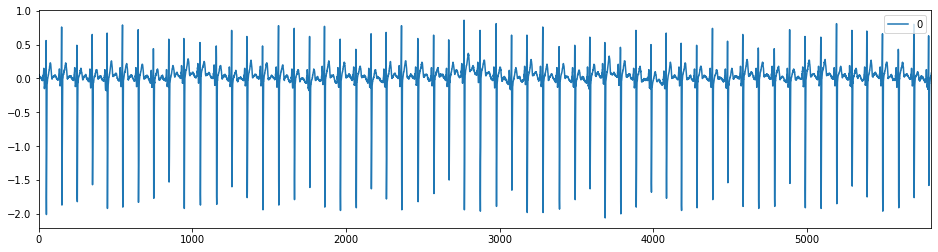

Testing for 99% of the test

result for ks on test is KstestResult(statistic=0.37219347877592585, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.3553325269465142, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.2569052301052684, pvalue=2.8551951746573345e-174)


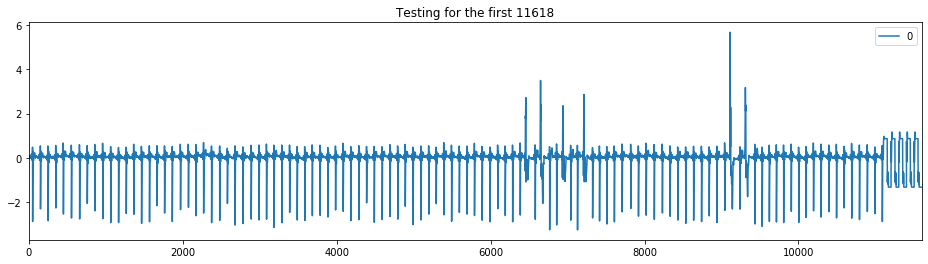

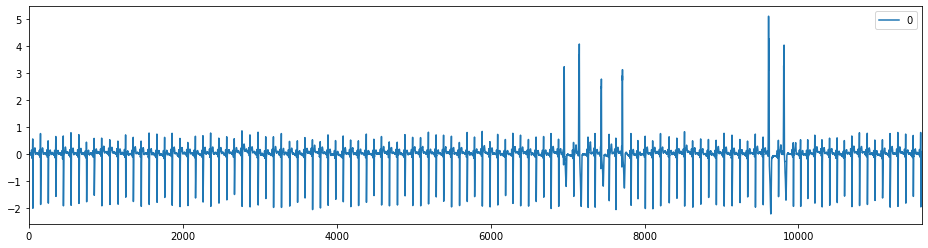

In [210]:
for i in [7,6,5,4,3,2,1]:
    X_test = []
    for j in range(15,int(11618/i)):
        X_test.append(inputs[j-15:j,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    predicted_heart_rate = multi_step_model.predict(X_test)
    if (pd.DataFrame(predicted_heart_rate)[0].shape[0] + 15) < 11000:
        test_pred = pd.DataFrame(test).iloc[15:(pd.DataFrame(predicted_heart_rate)[0].shape[0] + 15)]
    else:
        test_pred = pd.DataFrame(test)
    
    print(f'Testing for {int((test_pred.shape[0] / 11618) * 100)}% of the test')
    print('')
    ks_test = stats.kstest(np.array(pd.DataFrame(test_pred)[0]),'norm')
    ks_pred = stats.kstest(np.array(pd.DataFrame(predicted_heart_rate)[0]),'norm')
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(test_pred)[0]),np.array(pd.DataFrame(predicted_heart_rate)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(test_pred)[0])),(np.array(pd.DataFrame(predicted_heart_rate)[0])))}')
        #pass
    plt.figure(figsize=[20,10])
    plt.title(f'Testing for the first {int(11618/i)}')
    pd.DataFrame(predicted_heart_rate)[0].iloc[0:int(11618/i)].plot(figsize=(16,4),legend=True)
    pd.DataFrame(test).iloc[0:int(11618/i)].plot(figsize=(16,4),legend=True)
    plt.show()

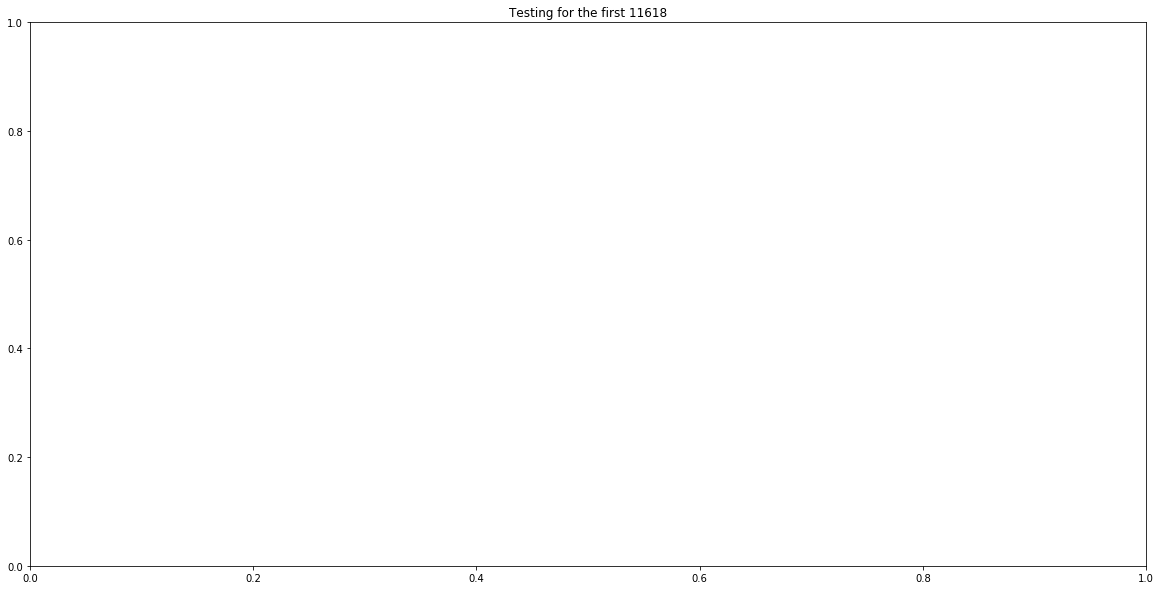

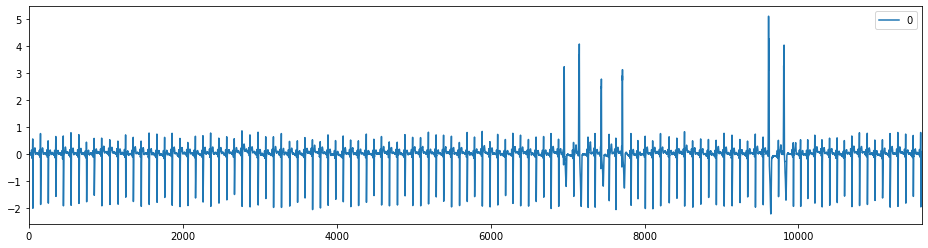

In [213]:
plt.figure(figsize=[20,10])
plt.title(f'Testing for the first {int(11618/i)}')
pd.DataFrame(test).iloc[0:int(11618/i)].plot(figsize=(16,4),legend=True)
plt.show()

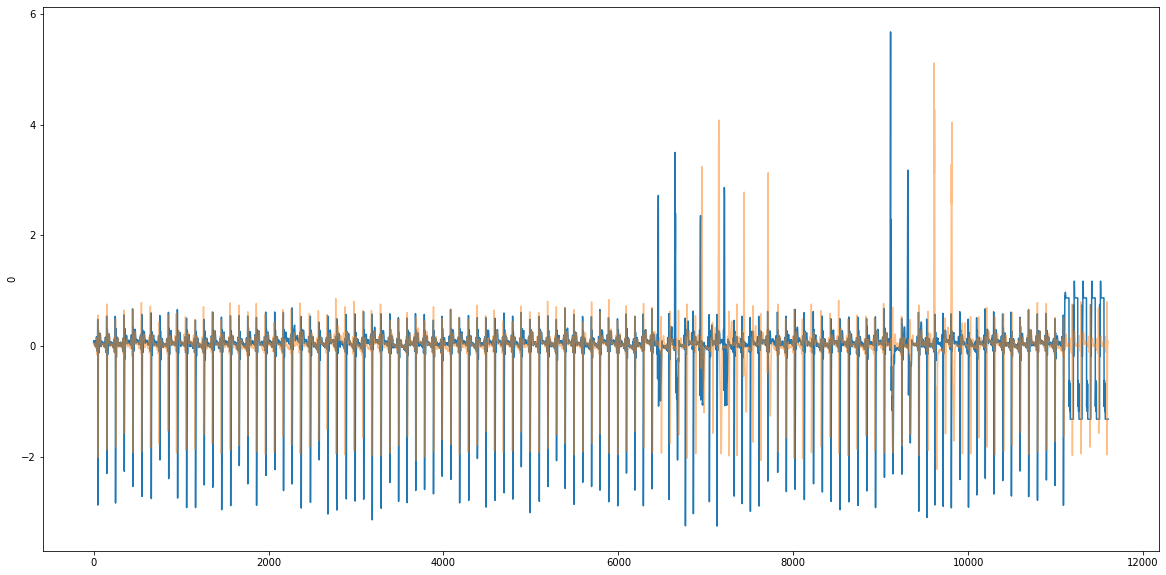

In [211]:
plt.figure(figsize=[20,10])
sns.lineplot(y=pd.DataFrame(predicted_heart_rate)[0],x=pd.DataFrame(predicted_heart_rate).index)
sns.lineplot(y=pd.DataFrame(test).iloc[0:int(11618/i)][0],x=pd.DataFrame(test).iloc[0:int(11618/i)].index,alpha=0.5)
plt.show()

In [212]:
pd.DataFrame(predicted_heart_rate)[0].iloc[0:int(11618)]

0        0.066694
1        0.092932
2        0.076453
3        0.088662
4        0.100058
           ...   
11598   -1.316332
11599   -1.316332
11600   -1.316332
11601   -1.316332
11602   -1.316332
Name: 0, Length: 11603, dtype: float32

In [166]:
test_pred

,0
0,0.05
1,0.06
2,0.04
3,0.05
4,0.05
...,...
11598,0.05
11599,0.05
11600,0.08
11601,0.09


In [167]:
merged = pd.merge(test_pred,pd.DataFrame(predicted_heart_rate),left_index=True,right_index=True).rename(columns={'0_x' : 'True','0_y' : 'Pred'})

In [168]:
merged.dtypes

True    float64
Pred    float32
dtype: object

In [169]:
merged['Pred'] = merged['Pred'].astype(float)

In [170]:
merged.dtypes

True    float64
Pred    float64
dtype: object

In [171]:
merged.to_csv('true_vs_pred.csv',encoding='UTF-8',sep=',')

![Amostra de súbida](sample.png)

## É notável que o modelo preve os pontos bem próximos do Real, percebemos pela imagem que o modelo leva um tempo para chegar aos 5.11 mV e ele decresce bem rápido também, todavia, capturando a mesma forma de onda.

## Esse momento ocorre em torno de 9600 ~ 9650 de index

### Realizando o treino com um momento específico de pico de mV

## Training from 9000:

In [57]:
train = df.iloc[16000:].values

In [58]:
train_size = df.iloc[16000:].shape[0]

In [59]:
test = df.iloc[:16000].values

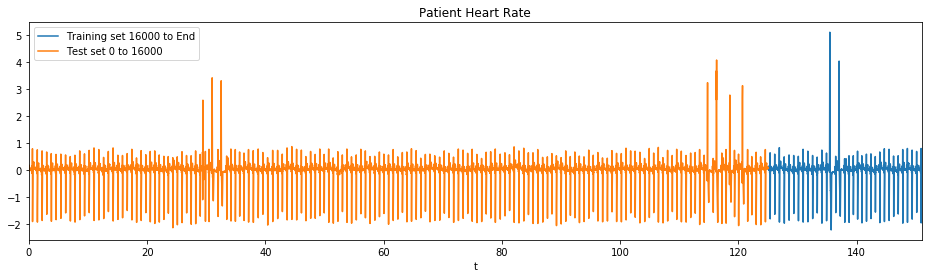

In [60]:
df["mV"].iloc[16000:].plot(figsize=(16,4),legend=True)
df["mV"].iloc[:16000].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set 16000 to End',f'Test set 0 to 16000'])
plt.title('Patient Heart Rate')
plt.show()

In [61]:
uni_data = df['mV']
uni_data.head()

t
0.000    0.16
0.008    0.18
0.016    0.17
0.023    0.18
0.031    0.18
Name: mV, dtype: float64

In [62]:
uni_data = uni_data.values

In [63]:
uni_train_mean = uni_data[16000:].mean()
uni_train_std = uni_data[16000:].std()

In [64]:
uni_train_mean

-0.015103386275097391

In [65]:
uni_train_std

0.44687218818325636

Let's standardize the data.

In [66]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [67]:
univariate_past_history = 15
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, int(train_size), None,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, 0, int(train_size),
                                       univariate_past_history,
                                       univariate_future_target)

# Model testing

In [68]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(1))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [69]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(1000).batch(500).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(500).repeat()

In [70]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=10,
                                          steps_per_epoch=100,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 4s 44ms/step - loss: 0.2878 - val_loss: 0.2093
Epoch 2/10
100/100 [==============================] - 2s 25ms/step - loss: 0.2170 - val_loss: 0.1619
Epoch 3/10
100/100 [==============================] - 2s 23ms/step - loss: 0.1747 - val_loss: 0.1372
Epoch 4/10
100/100 [==============================] - 2s 23ms/step - loss: 0.1556 - val_loss: 0.1239
Epoch 5/10
100/100 [==============================] - 2s 24ms/step - loss: 0.1340 - val_loss: 0.1108
Epoch 6/10
100/100 [==============================] - 2s 24ms/step - loss: 0.1200 - val_loss: 0.1046
Epoch 7/10
100/100 [==============================] - 2s 24ms/step - loss: 0.1108 - val_loss: 0.0976
Epoch 8/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0996 - val_loss: 0.07850s - l
Epoch 9/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0854 - val_loss: 0.0701
Epoch 10/10
100/100 [=====================

## Multi-Step Training

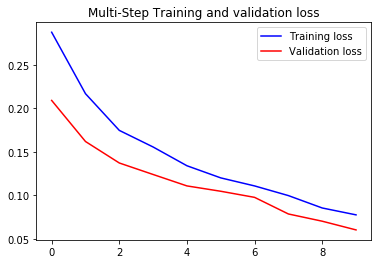

In [71]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [72]:
dataset_total = pd.concat((df["mV"].iloc[16000:],df["mV"].iloc[:16000]),axis=0)

In [73]:
len(dataset_total)-len(test)-15

3322

In [74]:
dataset_total.shape

(19337,)

In [75]:
19337 - 3322

16015

In [76]:
len(dataset_total)

19337

In [77]:
len(test)

16000

In [78]:
len(dataset_total)-len(test) + 15

3352

In [79]:
inputs = dataset_total.iloc[len(dataset_total)-len(test) - 15:].values
inputs = inputs.reshape(-1,1)
#inputs  = sc.transform(inputs)

In [80]:
inputs.shape

(16015, 1)

In [81]:
X_test = []
for j in range(15,16015):
    X_test.append(inputs[j-15:j,0])

In [82]:
X_test

[array([ 0.8 , -1.51, -1.96, -1.43, -1.2 , -0.44, -0.06, -0.02,  0.  ,
         0.04,  0.05,  0.05,  0.08,  0.09,  0.09]),
 array([-1.51, -1.96, -1.43, -1.2 , -0.44, -0.06, -0.02,  0.  ,  0.04,
         0.05,  0.05,  0.08,  0.09,  0.09,  0.16]),
 array([-1.96, -1.43, -1.2 , -0.44, -0.06, -0.02,  0.  ,  0.04,  0.05,
         0.05,  0.08,  0.09,  0.09,  0.16,  0.18]),
 array([-1.43, -1.2 , -0.44, -0.06, -0.02,  0.  ,  0.04,  0.05,  0.05,
         0.08,  0.09,  0.09,  0.16,  0.18,  0.17]),
 array([-1.2 , -0.44, -0.06, -0.02,  0.  ,  0.04,  0.05,  0.05,  0.08,
         0.09,  0.09,  0.16,  0.18,  0.17,  0.18]),
 array([-0.44, -0.06, -0.02,  0.  ,  0.04,  0.05,  0.05,  0.08,  0.09,
         0.09,  0.16,  0.18,  0.17,  0.18,  0.18]),
 array([-0.06, -0.02,  0.  ,  0.04,  0.05,  0.05,  0.08,  0.09,  0.09,
         0.16,  0.18,  0.17,  0.18,  0.18,  0.17]),
 array([-0.02,  0.  ,  0.04,  0.05,  0.05,  0.08,  0.09,  0.09,  0.16,
         0.18,  0.17,  0.18,  0.18,  0.17,  0.17]),
 array([0.  , 0.

In [83]:
X_test = np.array(X_test)

In [84]:
X_test

array([[ 0.8 , -1.51, -1.96, ...,  0.08,  0.09,  0.09],
       [-1.51, -1.96, -1.43, ...,  0.09,  0.09,  0.16],
       [-1.96, -1.43, -1.2 , ...,  0.09,  0.16,  0.18],
       ...,
       [ 0.05,  0.06,  0.06, ...,  0.09,  0.11,  0.08],
       [ 0.06,  0.06,  0.08, ...,  0.11,  0.08,  0.09],
       [ 0.06,  0.08,  0.08, ...,  0.08,  0.09,  0.1 ]])

In [85]:
X_test.shape

(16000, 15)

In [86]:
X_test.shape[0]

16000

In [87]:
X_test.shape[1]

15

In [88]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [89]:
predicted_heart_rate = multi_step_model.predict(X_test)

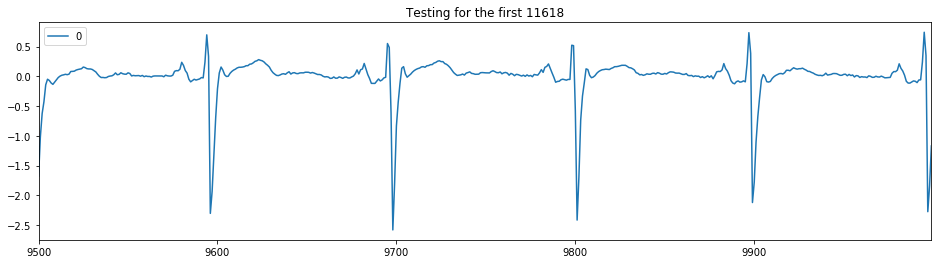

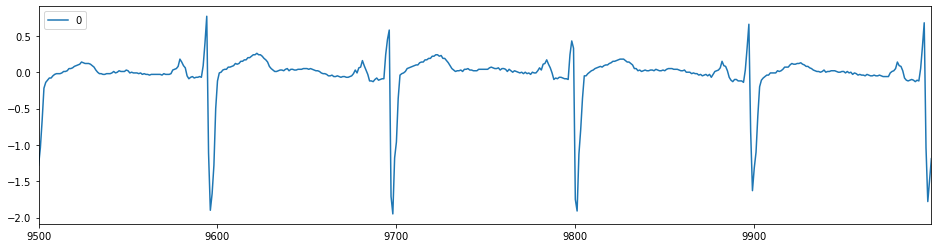

In [90]:
plt.figure(figsize=[20,10])
plt.title(f'Testing for the first {11618}')
pd.DataFrame(predicted_heart_rate)[0].iloc[9500:10000].plot(figsize=(16,4),legend=True)
pd.DataFrame(test).iloc[9500:10000].plot(figsize=(16,4),legend=True)
plt.show()

Testing for 14% of the test

result for ks on test is KstestResult(statistic=0.3871116853349386, pvalue=5.701587101295844e-307)
result for ks on prediction is KstestResult(statistic=0.39109490711312667, pvalue=1.47358290447e-313)
Results for spearman correlation is SpearmanrResult(correlation=0.09166902313144273, pvalue=1.2073189018001544e-05)


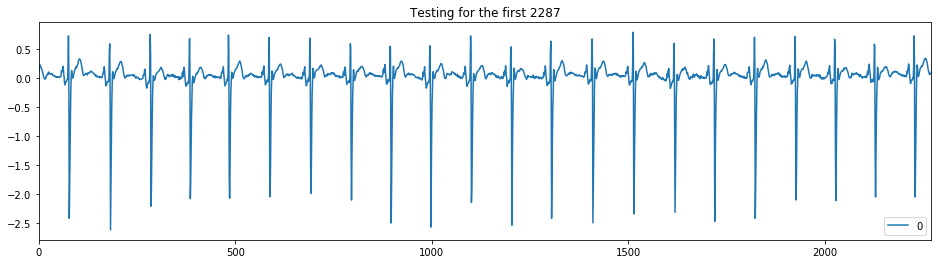

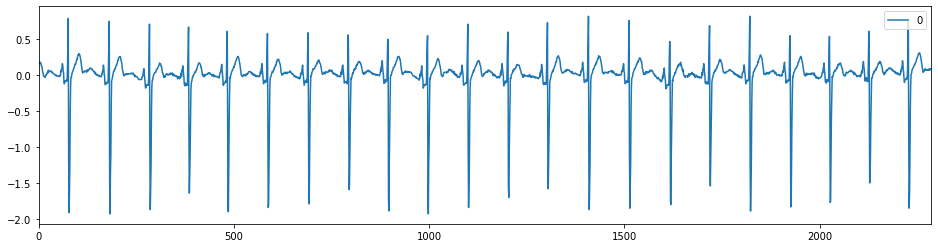

Testing for 16% of the test

result for ks on test is KstestResult(statistic=0.38705795299364143, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.39066770183170185, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.08354702348123796, pvalue=1.6355059436891408e-05)


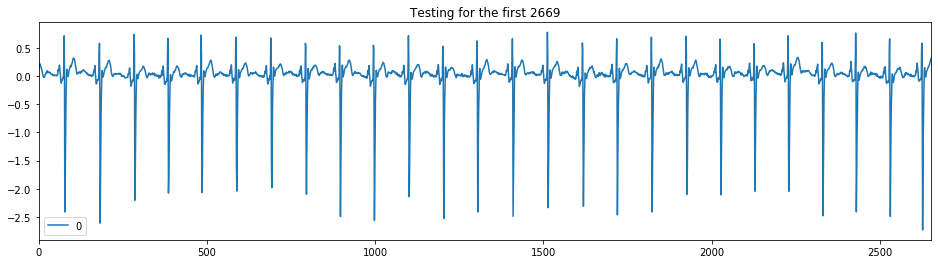

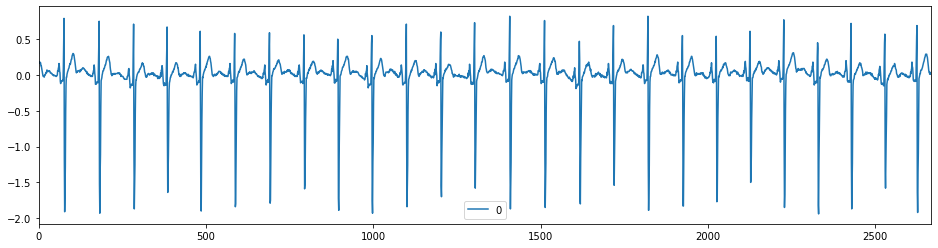

Testing for 19% of the test

result for ks on test is KstestResult(statistic=0.38535885341241227, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.3904145388306589, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.08253272081075322, pvalue=3.0692831331221893e-06)


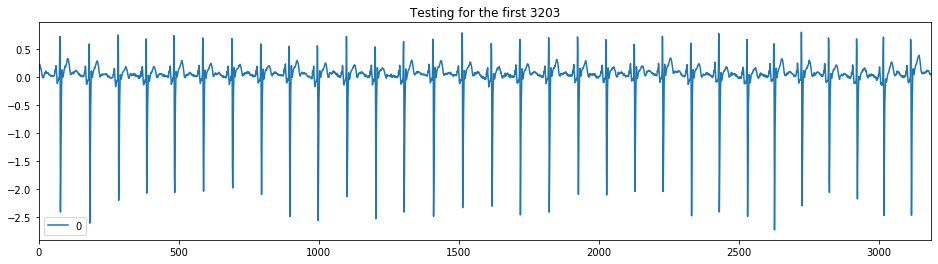

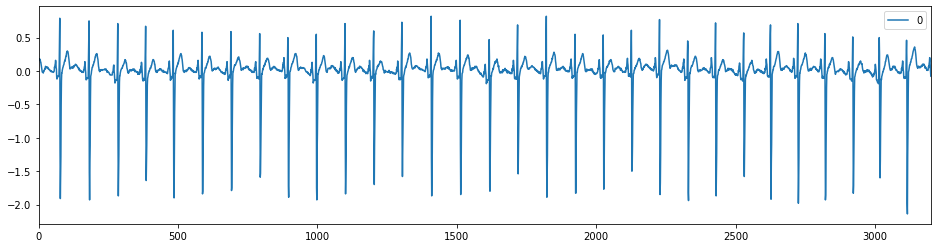

Testing for 24% of the test

result for ks on test is KstestResult(statistic=0.37386861104163616, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.37834819833970923, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.09450362941832988, pvalue=2.238549968676161e-09)


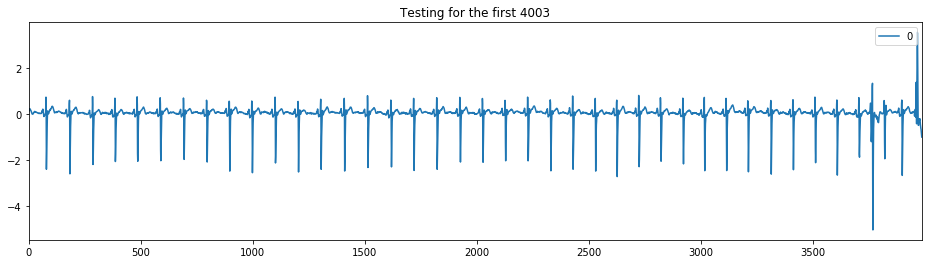

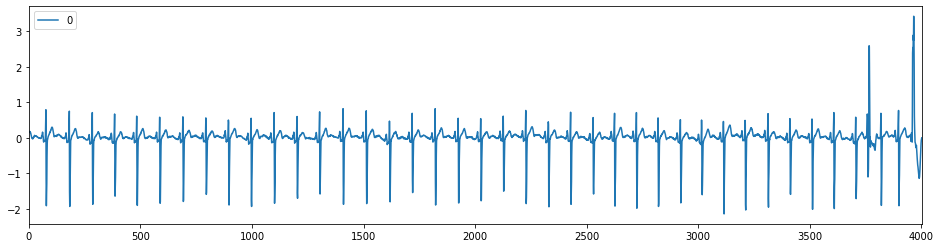

Testing for 33% of the test

result for ks on test is KstestResult(statistic=0.37312954432052603, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.3728308002659947, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.1296100954879348, pvalue=2.222111359445151e-21)


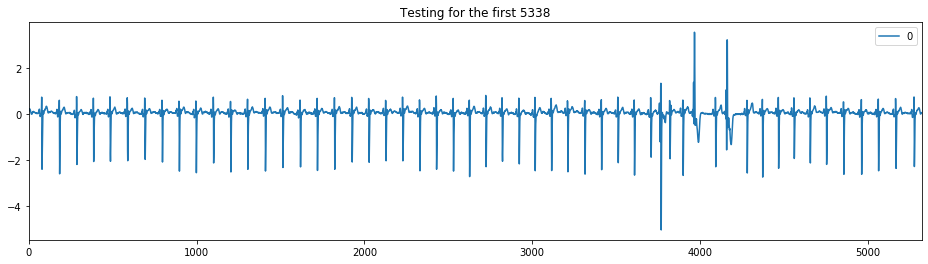

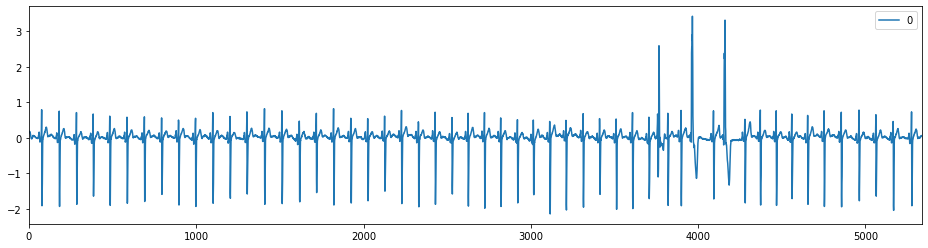

Testing for 49% of the test

result for ks on test is KstestResult(statistic=0.37738805325215163, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.37800611409475615, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.12916005582931556, pvalue=4.449393440751166e-31)


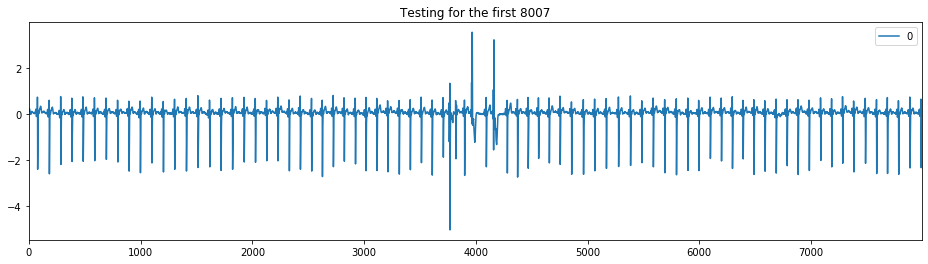

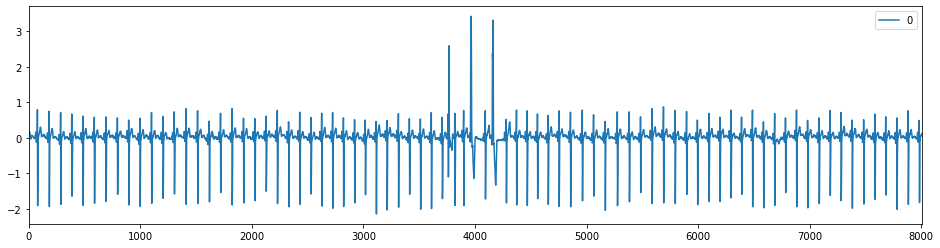

Testing for 99% of the test

result for ks on test is KstestResult(statistic=0.37639249519409357, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.37706040370458593, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.868966216008589, pvalue=0.0)


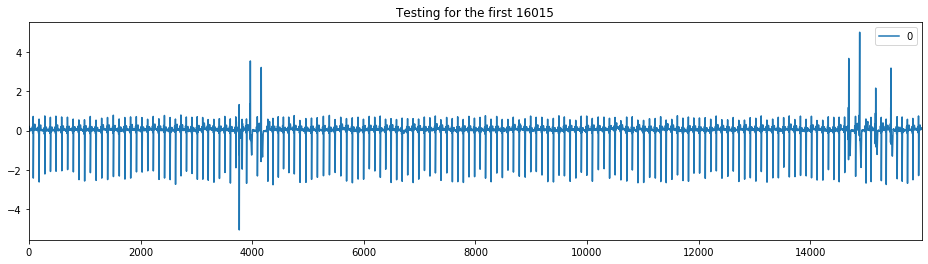

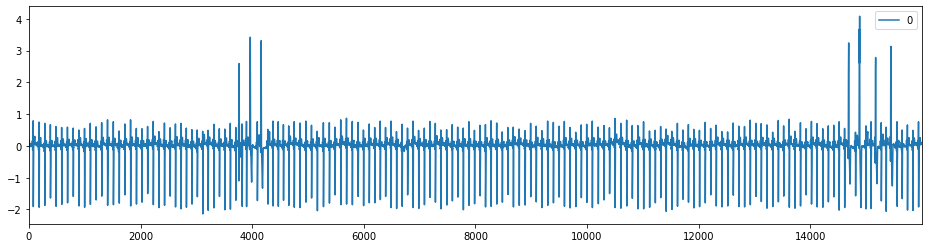

In [91]:
for i in [7,6,5,4,3,2,1]:
    X_test = []
    for j in range(15,int(16015/i)):
        X_test.append(inputs[j-15:j,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    predicted_heart_rate = multi_step_model.predict(X_test)
    if (pd.DataFrame(predicted_heart_rate)[0].shape[0] + 15) < 15900:
        test_pred = pd.DataFrame(test).iloc[15:(pd.DataFrame(predicted_heart_rate)[0].shape[0] + 15)]
    else:
        test_pred = pd.DataFrame(test)
    
    print(f'Testing for {int((test_pred.shape[0] / 16015) * 100)}% of the test')
    print('')
    ks_test = stats.kstest(np.array(pd.DataFrame(test_pred)[0]),'norm')
    ks_pred = stats.kstest(np.array(pd.DataFrame(predicted_heart_rate)[0]),'norm')
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(test_pred)[0]),np.array(pd.DataFrame(predicted_heart_rate)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(test_pred)[0])),(np.array(pd.DataFrame(predicted_heart_rate)[0])))}')
        #pass
    plt.figure(figsize=[20,10])
    plt.title(f'Testing for the first {int(16015/i)}')
    pd.DataFrame(predicted_heart_rate)[0].iloc[0:int(16015/i)].plot(figsize=(16,4),legend=True)
    pd.DataFrame(test).iloc[0:int(16015/i)].plot(figsize=(16,4),legend=True)
    plt.show()

### Os testes mostram que conseguimos pegar os picos, porém, não todos!

## Vamos tentar sobrepor os plots

In [92]:
pd.DataFrame(test).iloc[0:int(16015/i)]

,0
0,0.16
1,0.18
2,0.17
3,0.18
4,0.18
...,...
15995,0.11
15996,0.08
15997,0.09
15998,0.10


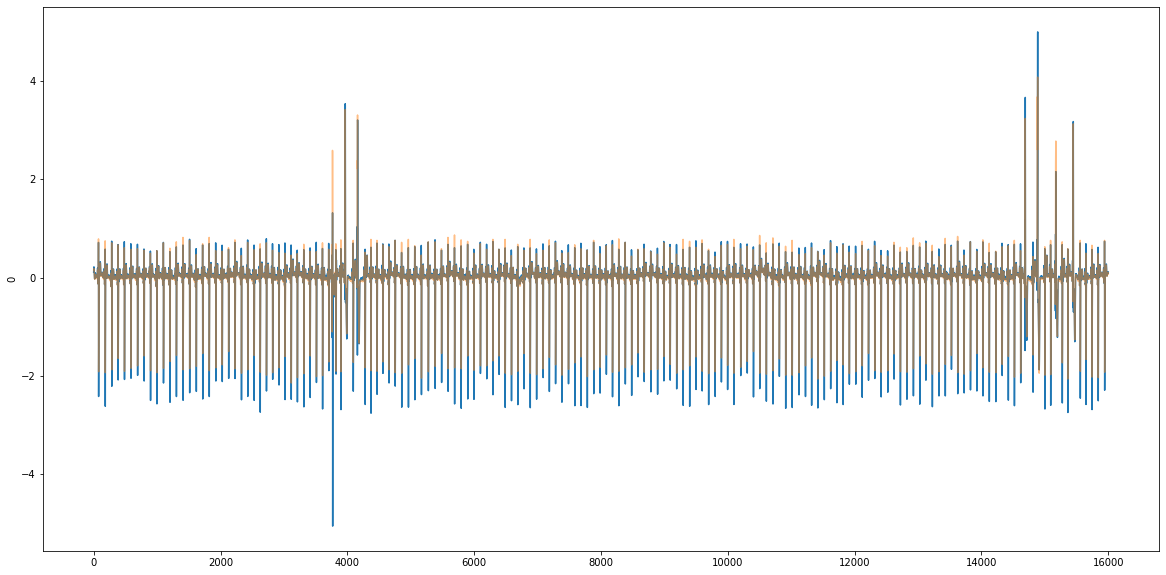

In [93]:
plt.figure(figsize=[20,10])
sns.lineplot(y=pd.DataFrame(predicted_heart_rate)[0],x=pd.DataFrame(predicted_heart_rate).index)
sns.lineplot(y=pd.DataFrame(test).iloc[0:int(16015/i)][0],x=pd.DataFrame(test).iloc[0:int(16015/i)].index,alpha=0.5)
plt.show()

### Acrescentar uma onda quadrada no meio dos sinais.
### Verificar se os batchs são sorteados de forma aleatória no tempo.
### Para verificar se é invariante mesmo
### Fazer a previsão do passado ( Já feita e o Futuro do mesmo! )
### Algoritmo de deslocamento no tempo com passo pequeno, e recalculando a correlação (Para descobrir o espaço onde a correlação é maxima).
### Fazer um gráfico da correlação em função do deslocamento temporal.
### Fazer o treinamento com o futuro, prever o passado e depois verificar com o futuro e ver quando ela se perde.

### Gráfico correlação em função do percentual de tempo do teste.
### Verificar se o algoritmo erra mais com menor percentual de tempo de previsão (Isso pode estar errado).

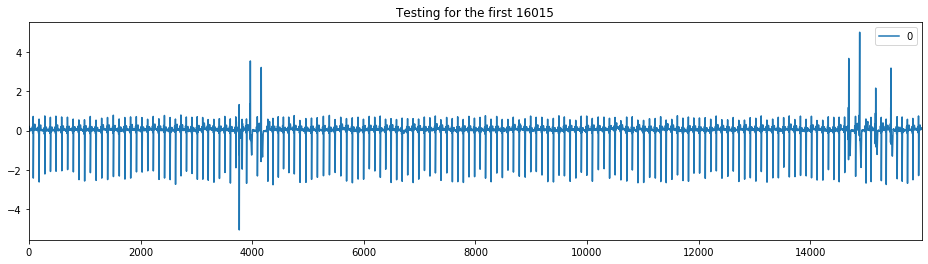

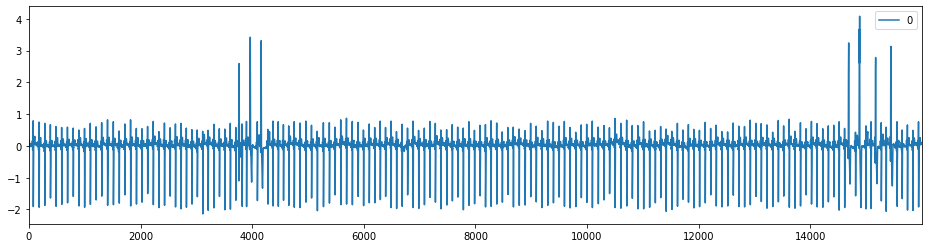

In [363]:
plt.title(f'Testing for the first {int(16015/i)}')
pd.DataFrame(predicted_heart_rate)[0].iloc[0:int(16015/i)].plot(figsize=(16,4),legend=True)
pd.DataFrame(test).iloc[0:int(16015/i)].plot(figsize=(16,4),legend=True)
plt.show()

### Treinar com trecho de anomalia e testar no resto (Que não seja este).
### Professor trazer os dados de morte subita.

### Criar um ruído aleatório no dado para fazer o filtro

### Ruído Elétrico Muscular
### Sinais Mioelétricos

#### Guyton Fisiologia 12 ed
#### entre 10 ~ 13